In [56]:
!pip install scikit-optimize
!pip install numpy

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

#Metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, explained_variance_score

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#Splitters
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view

#Hyperparameter optimization
from skopt import BayesSearchCV


# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [2]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied,initial_bikes
19867,19,8,4,2023,5,0,3,0,11.9,9.9,63.1,0.0,0.0,5.8,NaN,0.0
12579,3,9,6,2022,3,1,2,0,20.4,22.7,86.4,0.0,0.0,5.1,1.0,2.0
972,12,10,2,2021,2,1,3,0,13.3,8.9,59.0,0.0,0.0,22.7,1.0,22.0
14057,17,9,8,2022,1,1,3,3,31.2,32.3,44.0,0.0,0.0,10.5,1.0,8.0
187,19,8,1,2021,4,1,2,3,5.6,1.6,51.6,0.0,0.0,9.2,1.0,14.0


### **Estadísticas descriptivas**

In [3]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hour,25536.0,11.500000,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,15.712406,8.791936,1.0,8.00,16.0,23.00,31.0
month,25536.0,6.366541,3.366900,1.0,3.00,6.0,9.00,12.0
year,25536.0,2021.970865,0.810020,2021.0,2021.00,2022.0,2023.00,2023.0
week_day,25536.0,3.000000,2.000039,0.0,1.00,3.0,5.00,6.0
working_day,25536.0,0.683271,0.465210,0.0,0.00,1.0,1.00,1.0
class_day,25536.0,2.188910,0.931420,1.0,1.00,3.0,3.00,3.0
exits,25536.0,2.257206,3.678230,0.0,0.00,1.0,3.00,42.0
temperature,25536.0,16.985589,7.073900,-1.6,11.60,17.0,22.50,36.8
a_temperature,25536.0,16.598367,8.969706,-6.1,9.50,16.3,24.10,40.3


### **Tratamiento de valores faltantes**

In [4]:
# Contamos los valores faltantes en la columna 'demand_satisfied'
missing_values_count = data['demand_satisfied'].isna().sum()

missing_values_count

# Hacer INPLACE de demand_satisfied N.A provisional:
data['demand_satisfied'].fillna(False, inplace=True)

C:\Users\nicks\AppData\Local\Temp\ipykernel_3800\3785583287.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data['demand_satisfied'].fillna(False, inplace=True)


### **Adaptacion del dataset**

Transformamos 'year', 'month' y 'day' en un timestape que llamamos 'date' para poder filtrar los datos que usaremos. Tambien añadimos 'demand_satisfied_lag' que nos indica si la hora anterior se cumplio la demanda. Como hemos hecho el .fillna() esto no tendra missing values

In [5]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)

# Quitar los registros con valores faltantes
data.dropna(inplace=True)

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-11-01')
end_date = pd.Timestamp('2023-11-30')
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

filtered_data.drop('date', axis=1, inplace=True) #Eliminamos despues del filtrado date ya que es redundante


C:\Users\nicks\AppData\Local\Temp\ipykernel_3800\1063653604.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop('date', axis=1, inplace=True) #Eliminamos despues del filtrado date ya que es redundante


### **Distribución de las variables**

Obviamos las variables que hemos creado ya que estas son para ayudar al modelo o el filtrado, pero al ser hecha a partir de otras variables de nuestro dataset no son relevantes de graficar concretamente.

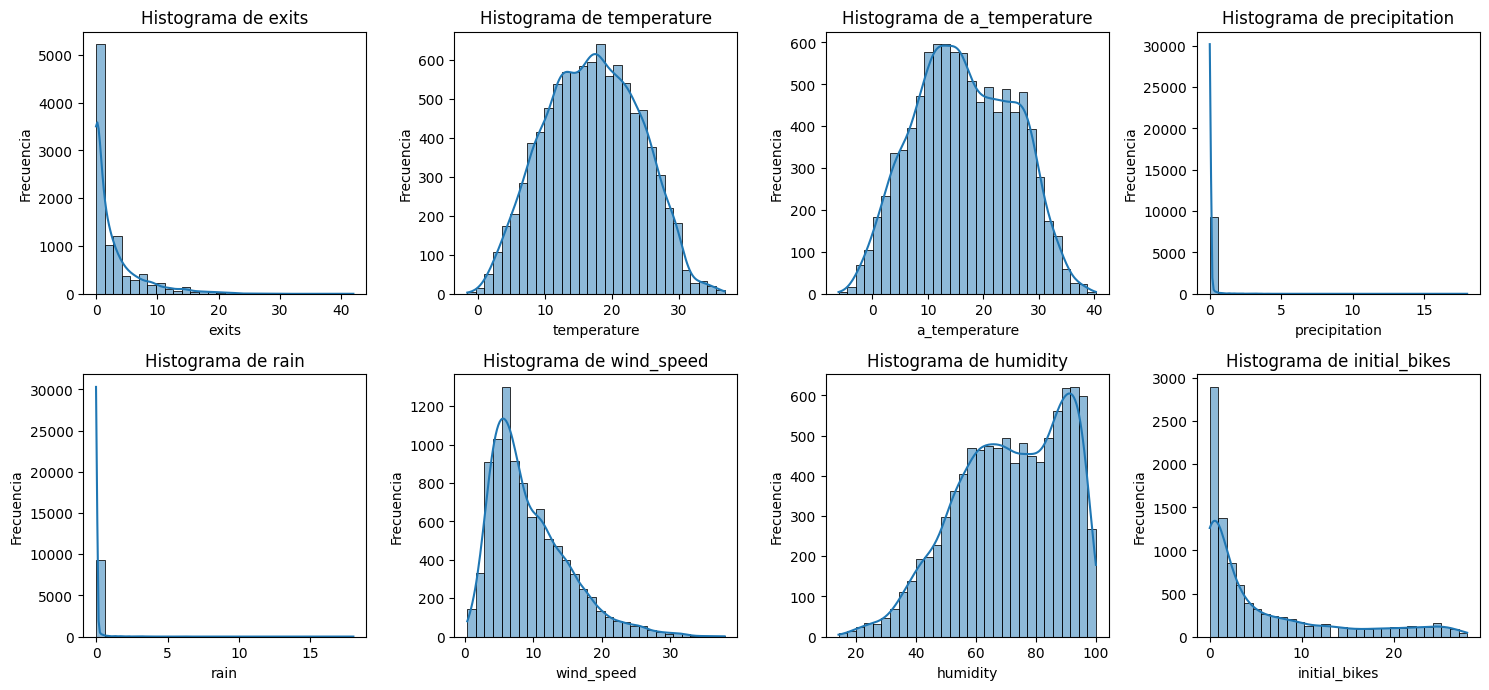

In [6]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity","initial_bikes"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(filtered_data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

Como vemos, rain y precipitation son casi lo mismo. Por lo que nos quedaremos tan solo con precipitation.

In [7]:
filtered_data.drop('rain', axis=1, inplace=True)


C:\Users\nicks\AppData\Local\Temp\ipykernel_3800\833453607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop('rain', axis=1, inplace=True)


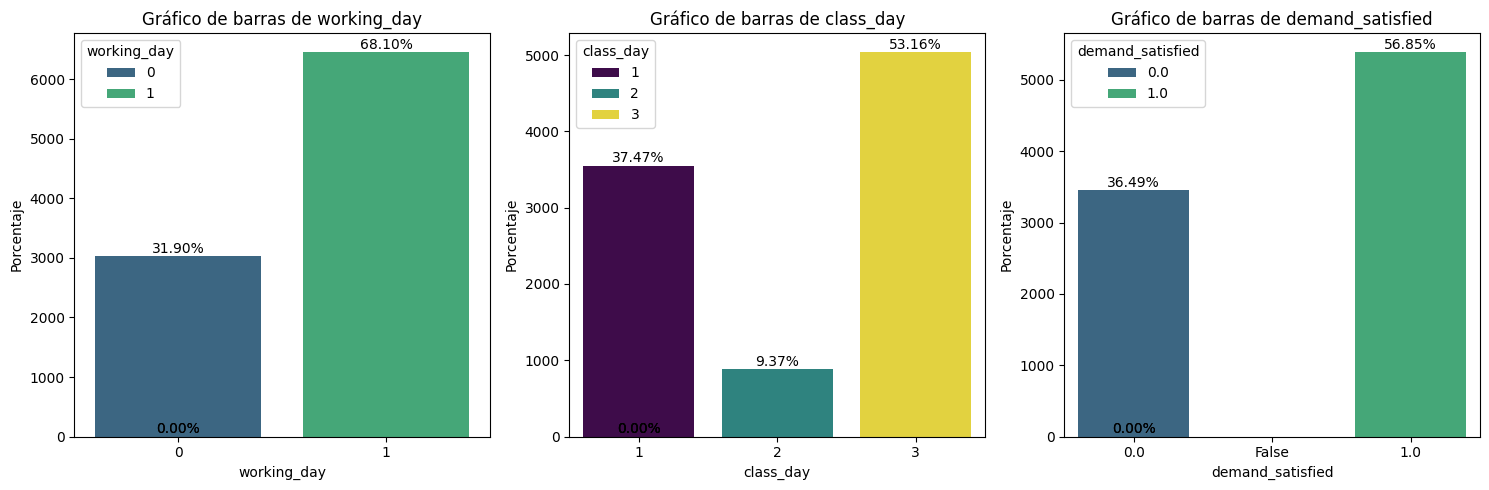

In [8]:
# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day', 'demand_satisfied']

# Plotting bar charts for categorical variables with percentages
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=var, data=filtered_data, hue=var, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')

    # Calculate the percentages and display them on the bars
    total = len(filtered_data[var])  # Total number of records for normalization
    for p in plt.gca().patches:
        height = p.get_height()  # Get the height of each bar
        # Put the annotation on the bar
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}%'.format((height / total) * 100),
                       ha="center", va='bottom')

plt.tight_layout()
plt.show();


### **Realción de la variable objetivo con el resto de variables**

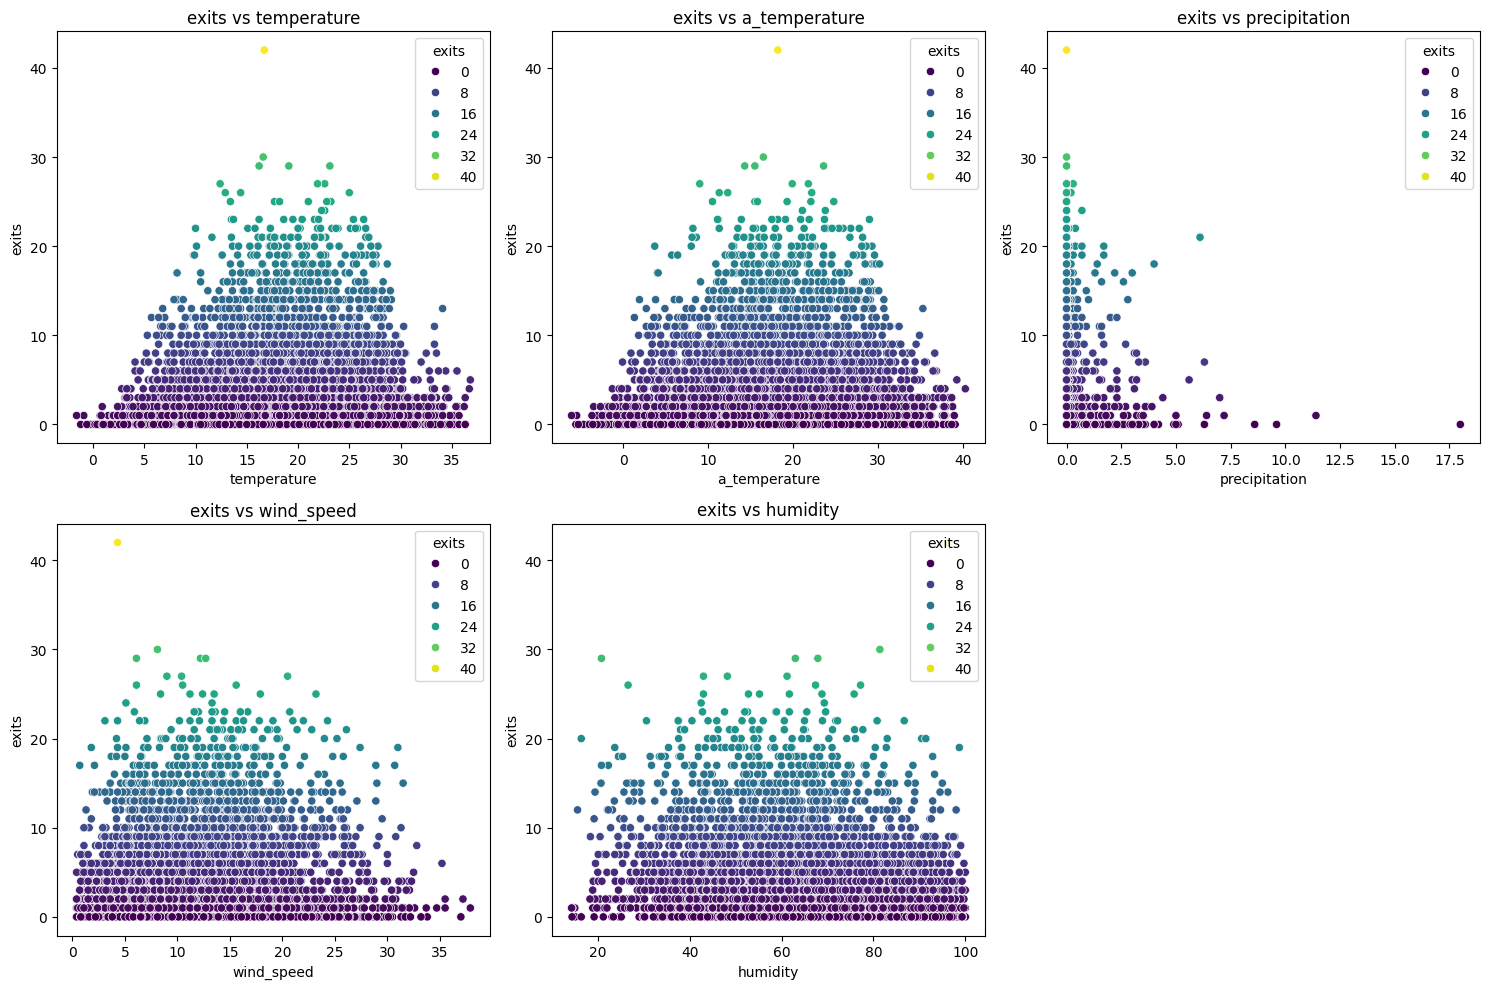

In [9]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=filtered_data, x=var, y="exits", hue='exits', palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

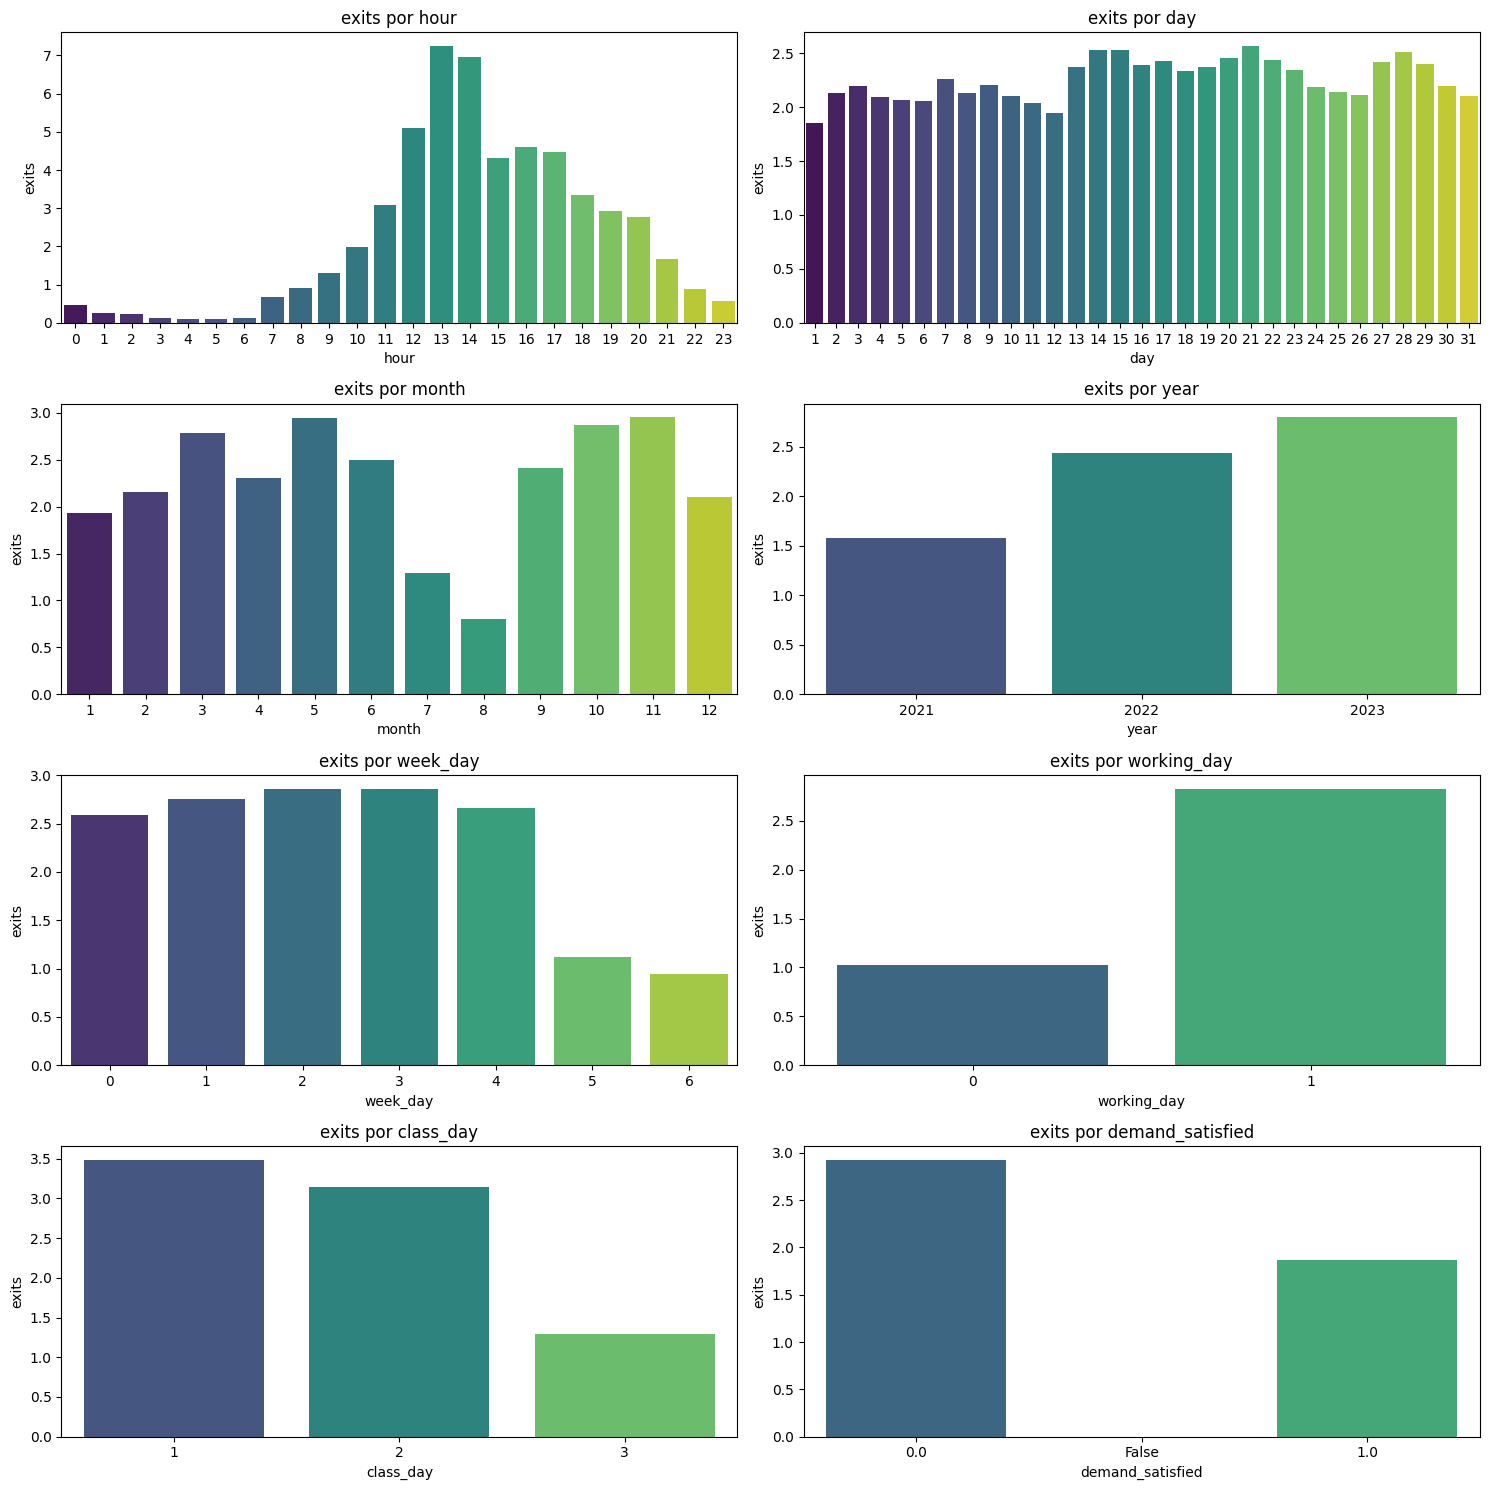

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None, palette="viridis")
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

<Axes: >

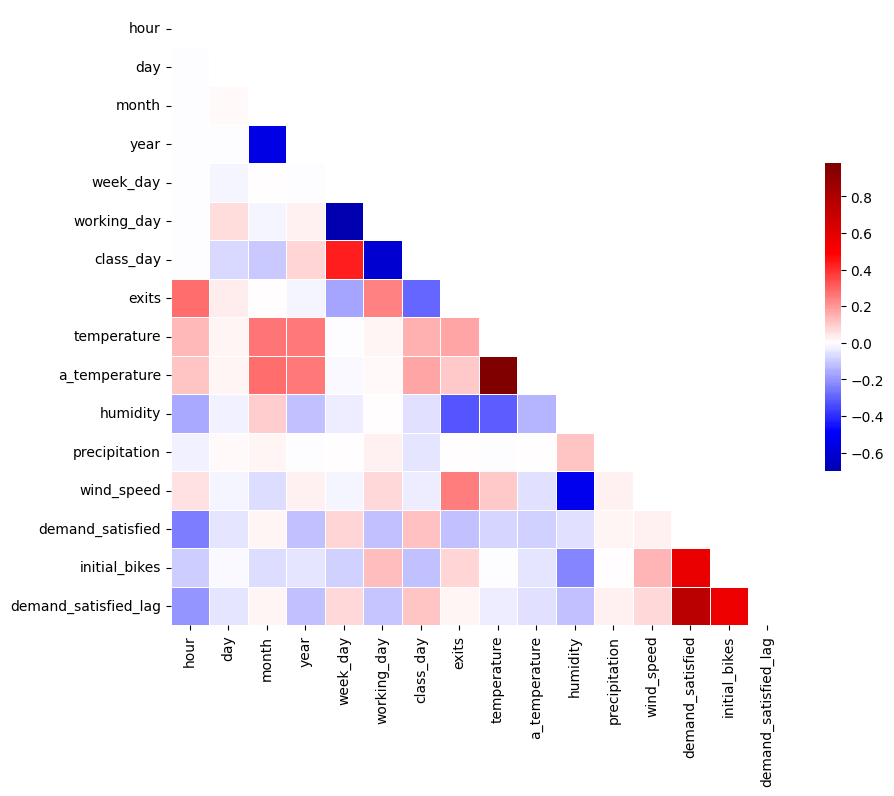

In [12]:
corr = filtered_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

---
# **Aplicacion de los modelos**
---

Creamos un dataframe llamada results_df para ir guardando y poder mejor las metricas de nuestros modelos

In [13]:
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE', 'RMSE', 'MAE', 'Explained Variance Score'])

## **Linear Regresion**

In [14]:
# Preparar los datos para la regresión
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

# Crear ventanas deslizantes
window_size = 24  # Tamaño de la ventana (ajustar según sea necesario)
X_windows = sliding_window_view(X.to_numpy(), window_shape=(window_size,), axis=0)
y_windows = y[window_size-1:].to_numpy()

# Aplanar las ventanas para usar en el modelo
X_windows_flat = X_windows.reshape(-1, window_size * X.shape[1])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_windows_flat, y_windows, test_size=0.15, shuffle=False)


In [20]:
# Create the linear regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = linear_reg.predict(X_test)

# Evaluate the model on the test set
r2_score = linear_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Add the results to the dataframe
results_df.loc[len(results_df)] = ["Linear Regression", r2_score, mse, sqrt(mse), mae, explained_variance]

results_df



,Model,R2 Score,MSE,RMSE,MAE,Explained Variance Score
0,Linear Regression,0.7089,6.772835,2.602467+0.000000j,1.836463,0.71694
1,Linear Regression,0.7089,6.772835,2.602467+0.000000j,1.836463,0.71694


### **K-Nearest Neighbours**

Per KNN cal normalitzar les variables numeriques

In [22]:
from sklearn.preprocessing import StandardScaler

# Copy the filtered_data DataFrame to filtered_data_normalized
filtered_data_normalized = filtered_data.copy()

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the variables in numeric_vars_without_exits
filtered_data_normalized[numeric_vars_without_exits] = scaler.fit_transform(filtered_data_normalized[numeric_vars_without_exits])

X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

# Crear ventanas deslizantes
window_size = 24  # Tamaño de la ventana (ajustar según sea necesario)
X_windows = sliding_window_view(X.to_numpy(), window_shape=(window_size,), axis=0)
y_windows = y[window_size-1:].to_numpy()

# Aplanar las ventanas para usar en el modelo
X_windows_flat = X_windows.reshape(-1, window_size * X.shape[1])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_windows_flat, y_windows, test_size=0.15, shuffle=False)

filtered_data_normalized.head()

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,wind_speed,demand_satisfied,initial_bikes,demand_satisfied_lag
16056,0,1,11,2022,1,0,3,0,0.126021,0.331314,1.283952,-0.136492,-0.523820,0.0,0.0,0.0
16057,1,1,11,2022,1,0,3,0,0.082893,0.150437,0.987828,0.548134,0.429880,0.0,0.0,0.0
16058,2,1,11,2022,1,0,3,0,0.097269,0.252180,1.166620,0.548134,-0.276564,1.0,2.0,0.0
16059,3,1,11,2022,1,0,3,1,0.039766,0.252180,1.267190,-0.136492,-0.806397,1.0,2.0,1.0
16060,4,1,11,2022,1,0,3,0,0.011014,0.218266,1.295127,-0.136492,-0.629786,1.0,3.0,1.0


In [ ]:
param_space_knn = {
    'n_neighbors': (3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the KNN model
knn = KNeighborsRegressor()

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for KNN
knn_bs = BayesSearchCV(
    knn,
    param_space_knn,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the KNN model with BayesSearchCV
knn_bs.fit(X_train, y_train)

# Best model and parameters found
best_knn_bs = knn_bs.best_estimator_
best_params_knn_bs = knn_bs.best_params_

# Evaluate the model on the test set
y_pred_knn_bs = best_knn_bs.predict(X_test)
r2_score_knn_bs = r2_score(y_test, y_pred_knn_bs)

# Print the best parameters and R2 score for KNN with BayesSearchCV
print("Best parameters for KNN (BayesSearchCV):", best_params_knn_bs)
mse_knn_bs = mean_squared_error(y_test, y_pred_knn_bs)
mae_knn_bs = mean_absolute_error(y_test, y_pred_knn_bs)
explained_variance_knn_bs = explained_variance_score(y_test, y_pred_knn_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["K-Nearest Neighbors", r2_score_knn_bs, mse_knn_bs, sqrt(mse_knn_bs), mae_knn_bs, explained_variance_knn_bs]

# Print or use results_df as needed
print(results_df)


### **SVM con Kernel POLY**

Para este modelo, no solo necesitamos estandarizar las variables numericas, sino tambien hara falta hace one-hot encoding de las variables numericas

In [ ]:
# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

# Perform one-hot encoding on the selected categorical variables
filtered_data_normalized_one = pd.get_dummies(filtered_data_normalized, columns=categorical_vars_selected)

filtered_data_normalized_one.head()


In [ ]:
# Define the parameter search space for SVM with polynomial kernel
param_space_svm_poly = {
    'C': (0.1, 10.0, 'log-uniform'),
    'gamma': ('scale', 'auto'),
    'degree': (2, 4)
}

# Create the SVM model with polynomial kernel
svm_poly = SVR(kernel='poly')

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for SVM with polynomial kernel
svm_poly_bs = BayesSearchCV(
    svm_poly,
    param_space_svm_poly,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the SVM model with BayesSearchCV
svm_poly_bs.fit(X_train, y_train)

# Best model and parameters found
best_svm_poly_bs = svm_poly_bs.best_estimator_
best_params_svm_poly_bs = svm_poly_bs.best_params_

# Evaluate the model on the test set
y_pred_svm_poly_bs = best_svm_poly_bs.predict(X_test)
r2_score_svm_poly_bs = r2_score(y_test, y_pred_svm_poly_bs)

# Print the best parameters and R2 score for SVM with polynomial kernel using BayesSearchCV
print("Best parameters for SVM with polynomial kernel (BayesSearchCV):", best_params_svm_poly_bs)
mse_svm_poly_bs = mean_squared_error(y_test, y_pred_svm_poly_bs)
mae_svm_poly_bs = mean_absolute_error(y_test, y_pred_svm_poly_bs)
explained_variance_svm_poly_bs = explained_variance_score(y_test, y_pred_svm_poly_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["SVM with Polynomial Kernel", r2_score_svm_poly_bs, mse_svm_poly_bs, sqrt(mse_svm_poly_bs), mae_svm_poly_bs, explained_variance_svm_poly_bs]

# Print or use results_df as needed
print(results_df)


## **Random Forest**

In [ ]:

# Preparar los datos para la regresión
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

# Crear ventanas deslizantes
window_size = 24  # Tamaño de la ventana (ajustar según sea necesario)
X_windows = sliding_window_view(X.to_numpy(), window_shape=(window_size,), axis=0)
y_windows = y[window_size-1:].to_numpy()

# Aplanar las ventanas para usar en el modelo
X_windows_flat = X_windows.reshape(-1, window_size * X.shape[1])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_windows_flat, y_windows, test_size=0.15, shuffle=False)


In [67]:
# Define the parameter grid
# param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    # 'max_features': ['auto', 'sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
}

# Crear el modelo Random Forest
rf = RandomForestRegressor()

# Configurar TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configurar BayesSearchCV
rf_bs = BayesSearchCV(
    rf,
    param_grid,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Ajustar el modelo con BayesSearchCV
rf_bs.fit(X_train, y_train)

# Mejor modelo y parámetros encontrados
best_rf = rf_bs.best_estimator_
best_params = rf_bs.best_params_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_rf.predict(X_test)
r2_score = r2_score(y_test, y_pred)

# Imprimir los mejores parámetros y el puntaje R2
print("Mejores parámetros:", best_params)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

results_df.loc[len(results_df)] = ["Random Forest", r2_score, mse, sqrt(mse), mae, explained_variance]

results_df

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales')

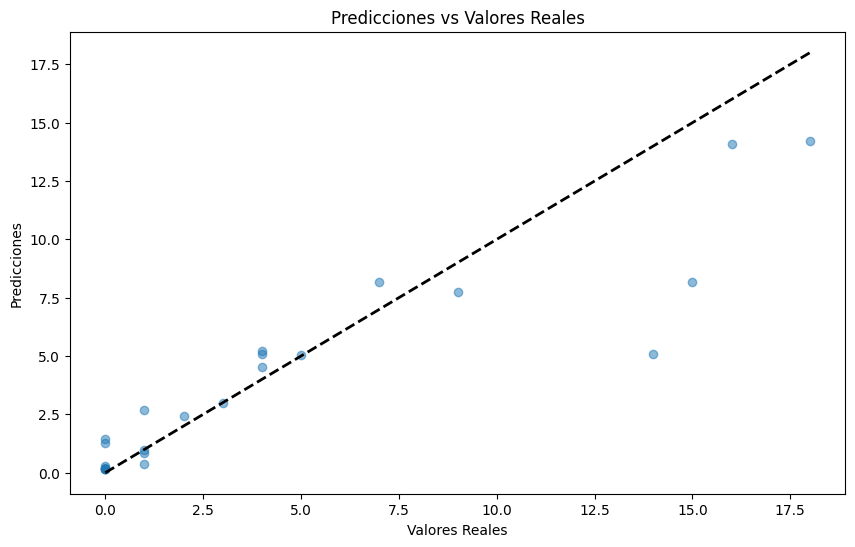

Root Mean Squared Error (RMSE): (2.562573676526572+0j)
Mean Squared Error (MSE): 6.566783847626913
Mean Absolute Error (MAE): 1.3966379977102645
Explained Variance Score: 0.8031246468244475


In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Comparación entre los valores reales y predichos')

Text(0.5, 0, 'Índice de los datos')

Text(0, 0.5, 'Salidas de bicis')

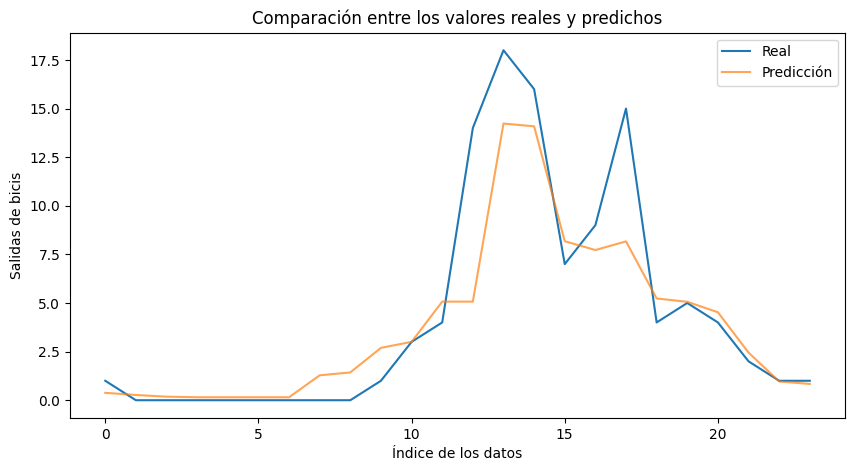

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();